In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from transformers import RobertaModel, AdamW
from transformers import RobertaTokenizer
import torch.optim as optim
from transformers import RobertaTokenizer
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
from torch.utils.data import Dataset, DataLoader
import nltk
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from tqdm import tqdm
from nltk.tokenize import sent_tokenize
import numpy as np

In [9]:
class BertAtt(nn.Module):
    def __init__(self, d_e, h):
        super(BertAtt, self).__init__()
        self.num_heads = h
        self.d_e = d_e
        self.head_dim = d_e // h
        
        self.q = nn.Linear(d_e, d_e)
        self.k = nn.Linear(d_e, d_e)
        self.v = nn.Linear(d_e, d_e)
        
        self.o = nn.Linear(d_e, d_e)
        self.layer_norm = nn.LayerNorm(d_e)
        
        self.dropout = nn.Dropout(dropout_prob)
        
    def forward(self, x):
        Q = self.q(x)
        K = self.k(x)
        V = self.v(x)
        
        Q = Q.view(Q.size(0), -1, self.num_heads, self.head_dim).permute(0, 2, 1, 3)
        K = K.view(K.size(0), -1, self.num_heads, self.head_dim).permute(0, 2, 1, 3)
        V = V.view(V.size(0), -1, self.num_heads, self.head_dim).permute(0, 2, 1, 3)
        
        
        attention_scores = torch.matmul(Q, K.permute(0, 1, 3, 2)) / (self.d_e**0.5)
        attention_probs = F.softmax(attention_scores, dim=-1)
        context = torch.matmul(attention_probs, V)
        
        context = context.permute(0, 2, 1, 3).contiguous()
        context = context.view(context.size(0), -1, self.num_heads*self.head_dim)
        context = self.dropout(context)
        context = self.o(context)
        
        return self.layer_norm(x + context)

class HBN(nn.Module):
    def __init__(self, d_e, h, m, n, y, dropout_prob=0.01, max_sentences=114):
        super(HBN, self).__init__()
        
        # Token-level Roberta encoder
        self.roberta = RobertaModel.from_pretrained("roberta-base")
        
        # Freeze Roberta weights
        for param in self.roberta.parameters():
            param.requires_grad = False
        
        # Sentence-level BERT Encoder
        self.bertatt = BertAtt(d_e, h)
        
        self.ff = nn.Sequential(
            nn.Linear(d_e, n*d_e),
            nn.ReLU(),
            nn.Linear(n*d_e, d_e)
        )
        self.layer_norm = nn.LayerNorm(d_e)
        
        self.multiple_bert_layers = nn.ModuleList([BertAtt(d_e, h) for _ in range(m)])
        
        self.transformation = nn.Linear(d_e, d_e)
        
        self.dropout = nn.Dropout(dropout_prob)
        
        # Prediction Layer
        self.predict = nn.Linear(d_e, y)
        
    def forward(self, input_ids, attention_mask):
#         print(input_ids.shape)
        # Token-level Roberta encoding
        roberta_outputs = self.roberta(input_ids=input_ids, attention_mask=attention_mask)[0]  # [batch_size, seq_length, hidden_size]
        
        # Average pooling to get sentence embeddings
        D = torch.mean(roberta_outputs, dim=1)  # [batch_size, hidden_size]
        
        out = self.bertatt(D)
        out = self.layer_norm(out + F.relu(self.ff(out)))
        
        Z = out
        for layer in self.multiple_bert_layers:
            Z = layer(Z)
        
        S = torch.tanh(torch.mean(Z, dim=1).mm(self.transformation.weight))
        S = self.dropout(S)
        scores = S.mm(self.predict.weight.t())
        
        return scores


In [10]:
# Parameters
d_e = 768  # Assuming you are using 'roberta-base'
h = 1     # Number of attention heads
m = 4      # Number of identical BERT layers
n = 4      # Scaling factor for feed-forward network
y = 2      # Number of classes, set this to your actual number
dropout_prob = 0.01 #dropout probability
samples = [50, 100, 150, 200]
num_epochs = 50
max_length = 128

In [11]:
# 1. Load and shuffle the data
train = pd.read_excel('/Vol1/sushant/Script/DLNLP/Assignment 1/ClassificationDataset-train1.xlsx')
train_combined = pd.DataFrame(columns=['Review', 'Label'])
train_combined['Review'] = pd.concat([train['Negative Review'], train['Positive Review']], ignore_index=True)
num_negative_reviews = len(train['Negative Review'])
train_combined['Label'] = [0] * num_negative_reviews + [1] * (len(train_combined) - num_negative_reviews)
df = train_combined.sample(frac=1, random_state=42).reset_index(drop=True)
positive_samples = df[df['Label'] == 1].sample(500)
negative_samples = df[df['Label'] == 0].sample(500)

data = pd.concat([positive_samples, negative_samples])
data = data.sample(frac=1).reset_index(drop=True)



In [12]:
auc_results = {}
for num_train_samples in samples:    
    # 2. Split data into train, validation, and test samples
    num_train_samples = num_train_samples
    num_val_samples = int(0.2 * num_train_samples)
    train_data = data.iloc[:num_train_samples]
    val_data = data.iloc[num_train_samples:num_train_samples+num_val_samples]
    test_data = data.iloc[num_train_samples+num_val_samples:]

    # 3. Preprocess and Flatten
    def preprocess_and_flatten(dataframe):
        reviews = dataframe['Review'].tolist()
        labels = dataframe['Label'].tolist()
        reviews = [review.lower() for review in reviews]
        reviews_sentences = [sent_tokenize(review) for review in reviews]
        flattened_reviews = [sentence for review in reviews_sentences for sentence in review]
        flattened_labels = [label for review, label in zip(reviews_sentences, labels) for sentence in review]
        return flattened_reviews, flattened_labels

    train_reviews, train_labels = preprocess_and_flatten(train_data)
    val_reviews, val_labels = preprocess_and_flatten(val_data)
    test_reviews, test_labels = preprocess_and_flatten(test_data)

    # 4. Tokenization
    tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
    train_tokens = tokenizer(train_reviews, padding=True, truncation=True, return_tensors="pt", max_length=max_length)
    val_tokens = tokenizer(val_reviews, padding=True, truncation=True, return_tensors="pt", max_length=max_length)
    test_tokens = tokenizer(test_reviews, padding=True, truncation=True, return_tensors="pt", max_length=max_length)

    # 5. Create DataLoader
    train_batch_size = 4
    val_batch_size = 4
    test_batch_size = 4

    train_dataset = TensorDataset(train_tokens['input_ids'], train_tokens['attention_mask'], torch.tensor(train_labels))
    val_dataset = TensorDataset(val_tokens['input_ids'], val_tokens['attention_mask'], torch.tensor(val_labels))
    test_dataset = TensorDataset(test_tokens['input_ids'], test_tokens['attention_mask'], torch.tensor(test_labels))

    train_loader = DataLoader(train_dataset, shuffle=True, batch_size=train_batch_size)
    val_loader = DataLoader(val_dataset, shuffle=False, batch_size=val_batch_size)
    test_loader = DataLoader(test_dataset, shuffle=False, batch_size=test_batch_size)

#     # Uncomment to test: iterating over the DataLoader
#     for batch in train_loader:
#         input_ids, attention_mask, labels = batch
#         print(f'num={num_train_samples }',input_ids.shape, attention_mask.shape, labels.shape)
#     len(train_loader.dataset),len(val_loader.dataset),len(test_loader.dataset)

    # Set device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Initialize the model
    model = HBN(d_e, h, m, n, y, dropout_prob).to(device)

    # Loss and Optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=2e-5, eps=1e-8)
    
    def train(model, dataloader, optimizer, criterion, device, epoch):
        model.train()
        total_loss = 0
        for batch in tqdm(dataloader, desc=f"Epoch {epoch + 1}/{num_epochs}"):
            input_ids, attention_mask, labels = batch

            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, labels)
            loss.backward()
    #         torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

            total_loss += loss.item()

        return total_loss / len(dataloader)

    def evaluate(model, dataloader, criterion, device):
        model.eval()
        total_loss = 0
        correct_predictions = 0
        all_preds = []
        all_labels = []

        with torch.no_grad():
            for batch in tqdm(dataloader):
                input_ids, attention_mask, labels = batch

                input_ids = input_ids.to(device)
                attention_mask = attention_mask.to(device)
                labels = labels.to(device)

                outputs = model(input_ids, attention_mask)
                loss = criterion(outputs, labels)
                total_loss += loss.item()

                _, preds = torch.max(outputs, dim=1)
                correct_predictions += torch.sum(preds == labels)

                # For AUC
                # Assuming binary classification; you need to get the probabilities for the positive class
                probs = torch.nn.functional.softmax(outputs, dim=1)[:, 1]
                all_preds.extend(probs.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        accuracy = correct_predictions.double() / len(dataloader.dataset)
        auc = roc_auc_score(all_labels, all_preds)
        return total_loss / len(dataloader), accuracy, auc

    # Actual Training Loop
    num_epochs = 50
    train_loss_epoch = []
    test_loss_epoch = []
    auc = []
    for epoch in range(num_epochs):
        train_loss = train(model, train_loader, optimizer, criterion, device, epoch)
        print(f"Train Loss: {train_loss:.4f}")
        test_loss, test_accuracy, test_auc = evaluate(model, test_loader, criterion, device)
        print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}, Test AUC: {test_auc:.4f}")
        train_loss_epoch.append(train_loss)
        test_loss_epoch.append(test_loss)
        auc.append(test_auc)
    auc_results[num_train_samples] = auc

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 1/50: 100%|██████████| 13/13 [00:03<00:00,  3.59it/s]


Train Loss: 0.7844


100%|██████████| 235/235 [00:48<00:00,  4.88it/s]


Test Loss: 0.6912, Test Accuracy: 0.5011, Test AUC: 0.6688


Epoch 2/50: 100%|██████████| 13/13 [00:03<00:00,  3.96it/s]


Train Loss: 0.7130


100%|██████████| 235/235 [00:48<00:00,  4.83it/s]


Test Loss: 0.6769, Test Accuracy: 0.5777, Test AUC: 0.7105


Epoch 3/50: 100%|██████████| 13/13 [00:03<00:00,  4.07it/s]


Train Loss: 0.6905


100%|██████████| 235/235 [00:48<00:00,  4.84it/s]


Test Loss: 0.6683, Test Accuracy: 0.6415, Test AUC: 0.7429


Epoch 4/50: 100%|██████████| 13/13 [00:03<00:00,  3.68it/s]


Train Loss: 0.6575


100%|██████████| 235/235 [00:48<00:00,  4.85it/s]


Test Loss: 0.6580, Test Accuracy: 0.7149, Test AUC: 0.7777


Epoch 5/50: 100%|██████████| 13/13 [00:03<00:00,  3.71it/s]


Train Loss: 0.6394


100%|██████████| 235/235 [00:48<00:00,  4.80it/s]


Test Loss: 0.6554, Test Accuracy: 0.6074, Test AUC: 0.7623


Epoch 6/50: 100%|██████████| 13/13 [00:03<00:00,  3.76it/s]


Train Loss: 0.6784


100%|██████████| 235/235 [00:49<00:00,  4.72it/s]


Test Loss: 0.6334, Test Accuracy: 0.6787, Test AUC: 0.7586


Epoch 7/50: 100%|██████████| 13/13 [00:03<00:00,  3.67it/s]


Train Loss: 0.6493


100%|██████████| 235/235 [00:49<00:00,  4.75it/s]


Test Loss: 0.6202, Test Accuracy: 0.7138, Test AUC: 0.7762


Epoch 8/50: 100%|██████████| 13/13 [00:03<00:00,  3.76it/s]


Train Loss: 0.6233


100%|██████████| 235/235 [00:49<00:00,  4.74it/s]


Test Loss: 0.6087, Test Accuracy: 0.7021, Test AUC: 0.7779


Epoch 9/50: 100%|██████████| 13/13 [00:03<00:00,  3.78it/s]


Train Loss: 0.5817


100%|██████████| 235/235 [00:47<00:00,  4.94it/s]


Test Loss: 0.5979, Test Accuracy: 0.6787, Test AUC: 0.7811


Epoch 10/50: 100%|██████████| 13/13 [00:03<00:00,  3.94it/s]


Train Loss: 0.5270


100%|██████████| 235/235 [00:48<00:00,  4.86it/s]


Test Loss: 0.5693, Test Accuracy: 0.7085, Test AUC: 0.7851


Epoch 11/50: 100%|██████████| 13/13 [00:03<00:00,  4.06it/s]


Train Loss: 0.4781


100%|██████████| 235/235 [00:47<00:00,  4.92it/s]


Test Loss: 0.6299, Test Accuracy: 0.6149, Test AUC: 0.7920


Epoch 12/50: 100%|██████████| 13/13 [00:03<00:00,  4.00it/s]


Train Loss: 0.4881


100%|██████████| 235/235 [00:49<00:00,  4.77it/s]


Test Loss: 0.5520, Test Accuracy: 0.6968, Test AUC: 0.8028


Epoch 13/50: 100%|██████████| 13/13 [00:03<00:00,  3.72it/s]


Train Loss: 0.4773


100%|██████████| 235/235 [00:50<00:00,  4.70it/s]


Test Loss: 0.5896, Test Accuracy: 0.7043, Test AUC: 0.8190


Epoch 14/50: 100%|██████████| 13/13 [00:03<00:00,  3.72it/s]


Train Loss: 0.3916


100%|██████████| 235/235 [00:47<00:00,  4.90it/s]


Test Loss: 0.5018, Test Accuracy: 0.7383, Test AUC: 0.8283


Epoch 15/50: 100%|██████████| 13/13 [00:03<00:00,  3.76it/s]


Train Loss: 0.3171


100%|██████████| 235/235 [00:48<00:00,  4.85it/s]


Test Loss: 0.5437, Test Accuracy: 0.7277, Test AUC: 0.8279


Epoch 16/50: 100%|██████████| 13/13 [00:03<00:00,  3.68it/s]


Train Loss: 0.3516


100%|██████████| 235/235 [00:47<00:00,  4.90it/s]


Test Loss: 0.5736, Test Accuracy: 0.7085, Test AUC: 0.8215


Epoch 17/50: 100%|██████████| 13/13 [00:03<00:00,  4.01it/s]


Train Loss: 0.2377


100%|██████████| 235/235 [00:49<00:00,  4.76it/s]


Test Loss: 0.8044, Test Accuracy: 0.6128, Test AUC: 0.8244


Epoch 18/50: 100%|██████████| 13/13 [00:03<00:00,  3.71it/s]


Train Loss: 0.3780


100%|██████████| 235/235 [00:49<00:00,  4.79it/s]


Test Loss: 0.7163, Test Accuracy: 0.7085, Test AUC: 0.8264


Epoch 19/50: 100%|██████████| 13/13 [00:03<00:00,  4.07it/s]


Train Loss: 0.3053


100%|██████████| 235/235 [00:48<00:00,  4.81it/s]


Test Loss: 0.5407, Test Accuracy: 0.7394, Test AUC: 0.8230


Epoch 20/50: 100%|██████████| 13/13 [00:03<00:00,  3.93it/s]


Train Loss: 0.2475


100%|██████████| 235/235 [00:49<00:00,  4.79it/s]


Test Loss: 0.6967, Test Accuracy: 0.6394, Test AUC: 0.8121


Epoch 21/50: 100%|██████████| 13/13 [00:03<00:00,  4.05it/s]


Train Loss: 0.2345


100%|██████████| 235/235 [00:49<00:00,  4.77it/s]


Test Loss: 0.6506, Test Accuracy: 0.6670, Test AUC: 0.8059


Epoch 22/50: 100%|██████████| 13/13 [00:03<00:00,  3.85it/s]


Train Loss: 0.2903


100%|██████████| 235/235 [00:48<00:00,  4.83it/s]


Test Loss: 0.6700, Test Accuracy: 0.6734, Test AUC: 0.8108


Epoch 23/50: 100%|██████████| 13/13 [00:03<00:00,  3.88it/s]


Train Loss: 0.1548


100%|██████████| 235/235 [00:49<00:00,  4.77it/s]


Test Loss: 0.6094, Test Accuracy: 0.7585, Test AUC: 0.8175


Epoch 24/50: 100%|██████████| 13/13 [00:03<00:00,  4.12it/s]


Train Loss: 0.2086


100%|██████████| 235/235 [00:48<00:00,  4.88it/s]


Test Loss: 0.6444, Test Accuracy: 0.7266, Test AUC: 0.8163


Epoch 25/50: 100%|██████████| 13/13 [00:03<00:00,  3.78it/s]


Train Loss: 0.2553


100%|██████████| 235/235 [00:49<00:00,  4.74it/s]


Test Loss: 0.8903, Test Accuracy: 0.6181, Test AUC: 0.8184


Epoch 26/50: 100%|██████████| 13/13 [00:03<00:00,  3.61it/s]


Train Loss: 0.5250


100%|██████████| 235/235 [00:49<00:00,  4.72it/s]


Test Loss: 0.7504, Test Accuracy: 0.7149, Test AUC: 0.8318


Epoch 27/50: 100%|██████████| 13/13 [00:03<00:00,  3.64it/s]


Train Loss: 0.1476


100%|██████████| 235/235 [00:49<00:00,  4.76it/s]


Test Loss: 0.7306, Test Accuracy: 0.6553, Test AUC: 0.8423


Epoch 28/50: 100%|██████████| 13/13 [00:03<00:00,  3.74it/s]


Train Loss: 0.2013


100%|██████████| 235/235 [00:49<00:00,  4.75it/s]


Test Loss: 0.5818, Test Accuracy: 0.7606, Test AUC: 0.8472


Epoch 29/50: 100%|██████████| 13/13 [00:03<00:00,  3.80it/s]


Train Loss: 0.1526


100%|██████████| 235/235 [00:48<00:00,  4.82it/s]


Test Loss: 0.6160, Test Accuracy: 0.7511, Test AUC: 0.8355


Epoch 30/50: 100%|██████████| 13/13 [00:03<00:00,  4.04it/s]


Train Loss: 0.1334


100%|██████████| 235/235 [00:48<00:00,  4.84it/s]


Test Loss: 0.6143, Test Accuracy: 0.7734, Test AUC: 0.8273


Epoch 31/50: 100%|██████████| 13/13 [00:03<00:00,  3.70it/s]


Train Loss: 0.1669


100%|██████████| 235/235 [00:48<00:00,  4.80it/s]


Test Loss: 0.8726, Test Accuracy: 0.6362, Test AUC: 0.8223


Epoch 32/50: 100%|██████████| 13/13 [00:03<00:00,  4.01it/s]


Train Loss: 0.2058


100%|██████████| 235/235 [00:49<00:00,  4.79it/s]


Test Loss: 0.7664, Test Accuracy: 0.6745, Test AUC: 0.8175


Epoch 33/50: 100%|██████████| 13/13 [00:03<00:00,  3.92it/s]


Train Loss: 0.1292


100%|██████████| 235/235 [00:48<00:00,  4.84it/s]


Test Loss: 0.8086, Test Accuracy: 0.6660, Test AUC: 0.8298


Epoch 34/50: 100%|██████████| 13/13 [00:03<00:00,  3.89it/s]


Train Loss: 0.1066


100%|██████████| 235/235 [00:48<00:00,  4.88it/s]


Test Loss: 0.6706, Test Accuracy: 0.7787, Test AUC: 0.8342


Epoch 35/50: 100%|██████████| 13/13 [00:03<00:00,  3.81it/s]


Train Loss: 0.0946


100%|██████████| 235/235 [00:49<00:00,  4.74it/s]


Test Loss: 0.7223, Test Accuracy: 0.7904, Test AUC: 0.8255


Epoch 36/50: 100%|██████████| 13/13 [00:03<00:00,  3.82it/s]


Train Loss: 0.1306


100%|██████████| 235/235 [00:47<00:00,  4.92it/s]


Test Loss: 0.8638, Test Accuracy: 0.6617, Test AUC: 0.8112


Epoch 37/50: 100%|██████████| 13/13 [00:03<00:00,  3.95it/s]


Train Loss: 0.1302


100%|██████████| 235/235 [00:47<00:00,  4.97it/s]


Test Loss: 0.8181, Test Accuracy: 0.7138, Test AUC: 0.8187


Epoch 38/50: 100%|██████████| 13/13 [00:02<00:00,  4.41it/s]


Train Loss: 0.1429


100%|██████████| 235/235 [00:47<00:00,  4.93it/s]


Test Loss: 0.7664, Test Accuracy: 0.7543, Test AUC: 0.8362


Epoch 39/50: 100%|██████████| 13/13 [00:03<00:00,  4.08it/s]


Train Loss: 0.1355


100%|██████████| 235/235 [00:48<00:00,  4.83it/s]


Test Loss: 0.8654, Test Accuracy: 0.7638, Test AUC: 0.8362


Epoch 40/50: 100%|██████████| 13/13 [00:03<00:00,  3.81it/s]


Train Loss: 0.1441


100%|██████████| 235/235 [00:49<00:00,  4.79it/s]


Test Loss: 0.8060, Test Accuracy: 0.7585, Test AUC: 0.8473


Epoch 41/50: 100%|██████████| 13/13 [00:03<00:00,  3.91it/s]


Train Loss: 0.1834


100%|██████████| 235/235 [00:49<00:00,  4.73it/s]


Test Loss: 0.8011, Test Accuracy: 0.7543, Test AUC: 0.8472


Epoch 42/50: 100%|██████████| 13/13 [00:03<00:00,  4.18it/s]


Train Loss: 0.0663


100%|██████████| 235/235 [00:46<00:00,  5.02it/s]


Test Loss: 0.7453, Test Accuracy: 0.7894, Test AUC: 0.8460


Epoch 43/50: 100%|██████████| 13/13 [00:03<00:00,  3.80it/s]


Train Loss: 0.1978


100%|██████████| 235/235 [00:48<00:00,  4.88it/s]


Test Loss: 0.6907, Test Accuracy: 0.7798, Test AUC: 0.8523


Epoch 44/50: 100%|██████████| 13/13 [00:03<00:00,  4.09it/s]


Train Loss: 0.1702


100%|██████████| 235/235 [00:48<00:00,  4.81it/s]


Test Loss: 0.7279, Test Accuracy: 0.7713, Test AUC: 0.8432


Epoch 45/50: 100%|██████████| 13/13 [00:03<00:00,  3.90it/s]


Train Loss: 0.1965


100%|██████████| 235/235 [00:48<00:00,  4.87it/s]


Test Loss: 0.7234, Test Accuracy: 0.7894, Test AUC: 0.8302


Epoch 46/50: 100%|██████████| 13/13 [00:03<00:00,  3.80it/s]


Train Loss: 0.2731


100%|██████████| 235/235 [00:48<00:00,  4.81it/s]


Test Loss: 1.0135, Test Accuracy: 0.6223, Test AUC: 0.8383


Epoch 47/50: 100%|██████████| 13/13 [00:03<00:00,  3.82it/s]


Train Loss: 0.1391


100%|██████████| 235/235 [00:49<00:00,  4.78it/s]


Test Loss: 0.6427, Test Accuracy: 0.7862, Test AUC: 0.8446


Epoch 48/50: 100%|██████████| 13/13 [00:03<00:00,  4.01it/s]


Train Loss: 0.1030


100%|██████████| 235/235 [00:49<00:00,  4.79it/s]


Test Loss: 0.7242, Test Accuracy: 0.7862, Test AUC: 0.8436


Epoch 49/50: 100%|██████████| 13/13 [00:03<00:00,  3.81it/s]


Train Loss: 0.0983


100%|██████████| 235/235 [00:49<00:00,  4.78it/s]


Test Loss: 0.7249, Test Accuracy: 0.7691, Test AUC: 0.8467


Epoch 50/50: 100%|██████████| 13/13 [00:03<00:00,  3.90it/s]


Train Loss: 0.1095


100%|██████████| 235/235 [00:48<00:00,  4.88it/s]


Test Loss: 0.7353, Test Accuracy: 0.7947, Test AUC: 0.8503


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 1/50: 100%|██████████| 25/25 [00:05<00:00,  4.22it/s]


Train Loss: 0.7036


100%|██████████| 220/220 [00:40<00:00,  5.44it/s]


Test Loss: 0.7643, Test Accuracy: 0.4989, Test AUC: 0.6970


Epoch 2/50: 100%|██████████| 25/25 [00:05<00:00,  4.40it/s]


Train Loss: 0.7078


100%|██████████| 220/220 [00:43<00:00,  5.05it/s]


Test Loss: 0.6655, Test Accuracy: 0.6420, Test AUC: 0.6922


Epoch 3/50: 100%|██████████| 25/25 [00:06<00:00,  3.86it/s]


Train Loss: 0.6619


100%|██████████| 220/220 [00:44<00:00,  4.94it/s]


Test Loss: 0.6503, Test Accuracy: 0.6534, Test AUC: 0.7185


Epoch 4/50: 100%|██████████| 25/25 [00:06<00:00,  3.82it/s]


Train Loss: 0.6445


100%|██████████| 220/220 [00:43<00:00,  5.03it/s]


Test Loss: 0.6517, Test Accuracy: 0.5159, Test AUC: 0.7703


Epoch 5/50: 100%|██████████| 25/25 [00:06<00:00,  3.88it/s]


Train Loss: 0.6241


100%|██████████| 220/220 [00:44<00:00,  4.99it/s]


Test Loss: 0.6139, Test Accuracy: 0.6636, Test AUC: 0.7777


Epoch 6/50: 100%|██████████| 25/25 [00:06<00:00,  3.82it/s]


Train Loss: 0.5285


100%|██████████| 220/220 [00:43<00:00,  5.03it/s]


Test Loss: 0.5628, Test Accuracy: 0.6818, Test AUC: 0.8191


Epoch 7/50: 100%|██████████| 25/25 [00:06<00:00,  3.94it/s]


Train Loss: 0.4837


100%|██████████| 220/220 [00:44<00:00,  4.91it/s]


Test Loss: 0.5116, Test Accuracy: 0.7216, Test AUC: 0.8297


Epoch 8/50: 100%|██████████| 25/25 [00:06<00:00,  3.98it/s]


Train Loss: 0.4642


100%|██████████| 220/220 [00:44<00:00,  4.95it/s]


Test Loss: 0.5510, Test Accuracy: 0.7307, Test AUC: 0.8526


Epoch 9/50: 100%|██████████| 25/25 [00:06<00:00,  4.12it/s]


Train Loss: 0.3754


100%|██████████| 220/220 [00:44<00:00,  4.97it/s]


Test Loss: 0.6229, Test Accuracy: 0.6909, Test AUC: 0.8587


Epoch 10/50: 100%|██████████| 25/25 [00:06<00:00,  3.96it/s]


Train Loss: 0.6579


100%|██████████| 220/220 [00:44<00:00,  4.98it/s]


Test Loss: 0.5863, Test Accuracy: 0.6977, Test AUC: 0.8611


Epoch 11/50: 100%|██████████| 25/25 [00:06<00:00,  3.98it/s]


Train Loss: 0.3595


100%|██████████| 220/220 [00:44<00:00,  4.91it/s]


Test Loss: 0.4698, Test Accuracy: 0.7705, Test AUC: 0.8612


Epoch 12/50: 100%|██████████| 25/25 [00:06<00:00,  3.85it/s]


Train Loss: 0.3813


100%|██████████| 220/220 [00:43<00:00,  5.02it/s]


Test Loss: 0.4813, Test Accuracy: 0.7875, Test AUC: 0.8726


Epoch 13/50: 100%|██████████| 25/25 [00:06<00:00,  4.14it/s]


Train Loss: 0.3010


100%|██████████| 220/220 [00:44<00:00,  4.97it/s]


Test Loss: 0.5096, Test Accuracy: 0.7864, Test AUC: 0.8785


Epoch 14/50: 100%|██████████| 25/25 [00:06<00:00,  4.03it/s]


Train Loss: 0.3200


100%|██████████| 220/220 [00:43<00:00,  5.08it/s]


Test Loss: 0.4817, Test Accuracy: 0.7716, Test AUC: 0.8839


Epoch 15/50: 100%|██████████| 25/25 [00:06<00:00,  3.85it/s]


Train Loss: 0.2833


100%|██████████| 220/220 [00:41<00:00,  5.28it/s]


Test Loss: 0.4770, Test Accuracy: 0.7761, Test AUC: 0.8813


Epoch 16/50: 100%|██████████| 25/25 [00:05<00:00,  4.48it/s]


Train Loss: 0.2794


100%|██████████| 220/220 [00:39<00:00,  5.64it/s]


Test Loss: 0.4614, Test Accuracy: 0.7966, Test AUC: 0.8988


Epoch 17/50: 100%|██████████| 25/25 [00:05<00:00,  4.22it/s]


Train Loss: 0.2996


100%|██████████| 220/220 [00:44<00:00,  4.96it/s]


Test Loss: 0.4022, Test Accuracy: 0.8193, Test AUC: 0.9087


Epoch 18/50: 100%|██████████| 25/25 [00:06<00:00,  3.93it/s]


Train Loss: 0.2254


100%|██████████| 220/220 [00:44<00:00,  4.93it/s]


Test Loss: 0.4269, Test Accuracy: 0.8205, Test AUC: 0.9105


Epoch 19/50: 100%|██████████| 25/25 [00:06<00:00,  3.95it/s]


Train Loss: 0.2202


100%|██████████| 220/220 [00:45<00:00,  4.86it/s]


Test Loss: 0.4088, Test Accuracy: 0.8250, Test AUC: 0.9126


Epoch 20/50: 100%|██████████| 25/25 [00:06<00:00,  3.79it/s]


Train Loss: 0.2774


100%|██████████| 220/220 [00:44<00:00,  4.90it/s]


Test Loss: 0.4325, Test Accuracy: 0.8239, Test AUC: 0.9159


Epoch 21/50: 100%|██████████| 25/25 [00:06<00:00,  3.90it/s]


Train Loss: 0.3808


100%|██████████| 220/220 [00:44<00:00,  4.90it/s]


Test Loss: 0.5823, Test Accuracy: 0.7648, Test AUC: 0.9073


Epoch 22/50: 100%|██████████| 25/25 [00:06<00:00,  3.89it/s]


Train Loss: 0.2978


100%|██████████| 220/220 [00:44<00:00,  4.96it/s]


Test Loss: 0.3954, Test Accuracy: 0.8250, Test AUC: 0.9137


Epoch 23/50: 100%|██████████| 25/25 [00:06<00:00,  4.00it/s]


Train Loss: 0.2429


100%|██████████| 220/220 [00:45<00:00,  4.87it/s]


Test Loss: 0.3908, Test Accuracy: 0.8227, Test AUC: 0.9146


Epoch 24/50: 100%|██████████| 25/25 [00:06<00:00,  3.88it/s]


Train Loss: 0.1742


100%|██████████| 220/220 [00:44<00:00,  4.94it/s]


Test Loss: 0.4582, Test Accuracy: 0.8432, Test AUC: 0.9203


Epoch 25/50: 100%|██████████| 25/25 [00:06<00:00,  3.85it/s]


Train Loss: 0.1777


100%|██████████| 220/220 [00:44<00:00,  4.93it/s]


Test Loss: 0.4012, Test Accuracy: 0.8534, Test AUC: 0.9212


Epoch 26/50: 100%|██████████| 25/25 [00:06<00:00,  3.98it/s]


Train Loss: 0.2552


100%|██████████| 220/220 [00:44<00:00,  4.99it/s]


Test Loss: 0.3972, Test Accuracy: 0.8466, Test AUC: 0.9173


Epoch 27/50: 100%|██████████| 25/25 [00:06<00:00,  3.78it/s]


Train Loss: 0.1103


100%|██████████| 220/220 [00:44<00:00,  4.89it/s]


Test Loss: 0.4133, Test Accuracy: 0.8466, Test AUC: 0.9148


Epoch 28/50: 100%|██████████| 25/25 [00:06<00:00,  3.98it/s]


Train Loss: 0.1864


100%|██████████| 220/220 [00:45<00:00,  4.88it/s]


Test Loss: 0.4346, Test Accuracy: 0.8239, Test AUC: 0.9193


Epoch 29/50: 100%|██████████| 25/25 [00:06<00:00,  3.92it/s]


Train Loss: 0.1983


100%|██████████| 220/220 [00:44<00:00,  4.93it/s]


Test Loss: 0.5796, Test Accuracy: 0.8023, Test AUC: 0.9218


Epoch 30/50: 100%|██████████| 25/25 [00:06<00:00,  3.84it/s]


Train Loss: 0.1622


100%|██████████| 220/220 [00:44<00:00,  4.95it/s]


Test Loss: 0.4679, Test Accuracy: 0.8216, Test AUC: 0.9227


Epoch 31/50: 100%|██████████| 25/25 [00:06<00:00,  3.85it/s]


Train Loss: 0.1157


100%|██████████| 220/220 [00:40<00:00,  5.38it/s]


Test Loss: 0.4435, Test Accuracy: 0.8455, Test AUC: 0.9229


Epoch 32/50: 100%|██████████| 25/25 [00:05<00:00,  4.59it/s]


Train Loss: 0.2011


100%|██████████| 220/220 [00:43<00:00,  5.09it/s]


Test Loss: 0.4993, Test Accuracy: 0.8409, Test AUC: 0.9163


Epoch 33/50: 100%|██████████| 25/25 [00:06<00:00,  3.95it/s]


Train Loss: 0.1812


100%|██████████| 220/220 [00:42<00:00,  5.19it/s]


Test Loss: 0.4458, Test Accuracy: 0.8534, Test AUC: 0.9057


Epoch 34/50: 100%|██████████| 25/25 [00:06<00:00,  3.93it/s]


Train Loss: 0.2149


100%|██████████| 220/220 [00:43<00:00,  5.02it/s]


Test Loss: 0.4436, Test Accuracy: 0.8557, Test AUC: 0.9245


Epoch 35/50: 100%|██████████| 25/25 [00:06<00:00,  3.97it/s]


Train Loss: 0.1302


100%|██████████| 220/220 [00:44<00:00,  4.90it/s]


Test Loss: 0.4004, Test Accuracy: 0.8648, Test AUC: 0.9284


Epoch 36/50: 100%|██████████| 25/25 [00:06<00:00,  3.92it/s]


Train Loss: 0.0933


100%|██████████| 220/220 [00:44<00:00,  4.93it/s]


Test Loss: 0.4560, Test Accuracy: 0.8545, Test AUC: 0.9224


Epoch 37/50: 100%|██████████| 25/25 [00:06<00:00,  3.89it/s]


Train Loss: 0.1954


100%|██████████| 220/220 [00:44<00:00,  4.98it/s]


Test Loss: 0.4483, Test Accuracy: 0.8534, Test AUC: 0.9151


Epoch 38/50: 100%|██████████| 25/25 [00:06<00:00,  3.78it/s]


Train Loss: 0.0970


100%|██████████| 220/220 [00:44<00:00,  4.90it/s]


Test Loss: 0.5606, Test Accuracy: 0.8364, Test AUC: 0.9180


Epoch 39/50: 100%|██████████| 25/25 [00:06<00:00,  3.83it/s]


Train Loss: 0.1095


100%|██████████| 220/220 [00:44<00:00,  4.92it/s]


Test Loss: 0.6084, Test Accuracy: 0.8068, Test AUC: 0.9262


Epoch 40/50: 100%|██████████| 25/25 [00:06<00:00,  3.93it/s]


Train Loss: 0.1001


100%|██████████| 220/220 [00:44<00:00,  4.93it/s]


Test Loss: 0.4395, Test Accuracy: 0.8591, Test AUC: 0.9275


Epoch 41/50: 100%|██████████| 25/25 [00:06<00:00,  3.98it/s]


Train Loss: 0.0772


100%|██████████| 220/220 [00:45<00:00,  4.81it/s]


Test Loss: 0.5232, Test Accuracy: 0.8398, Test AUC: 0.9304


Epoch 42/50: 100%|██████████| 25/25 [00:06<00:00,  3.84it/s]


Train Loss: 0.1356


100%|██████████| 220/220 [00:43<00:00,  5.01it/s]


Test Loss: 0.5036, Test Accuracy: 0.8511, Test AUC: 0.9186


Epoch 43/50: 100%|██████████| 25/25 [00:06<00:00,  3.85it/s]


Train Loss: 0.0743


100%|██████████| 220/220 [00:43<00:00,  5.04it/s]


Test Loss: 0.4469, Test Accuracy: 0.8705, Test AUC: 0.9291


Epoch 44/50: 100%|██████████| 25/25 [00:06<00:00,  3.88it/s]


Train Loss: 0.0434


100%|██████████| 220/220 [00:44<00:00,  4.92it/s]


Test Loss: 0.4703, Test Accuracy: 0.8716, Test AUC: 0.9300


Epoch 45/50: 100%|██████████| 25/25 [00:06<00:00,  4.04it/s]


Train Loss: 0.1121


100%|██████████| 220/220 [00:44<00:00,  4.99it/s]


Test Loss: 0.5547, Test Accuracy: 0.8545, Test AUC: 0.9221


Epoch 46/50: 100%|██████████| 25/25 [00:06<00:00,  4.01it/s]


Train Loss: 0.0751


100%|██████████| 220/220 [00:43<00:00,  5.02it/s]


Test Loss: 0.5012, Test Accuracy: 0.8580, Test AUC: 0.9252


Epoch 47/50: 100%|██████████| 25/25 [00:06<00:00,  3.99it/s]


Train Loss: 0.1494


100%|██████████| 220/220 [00:43<00:00,  5.06it/s]


Test Loss: 0.6886, Test Accuracy: 0.8000, Test AUC: 0.9272


Epoch 48/50: 100%|██████████| 25/25 [00:06<00:00,  3.90it/s]


Train Loss: 0.1653


100%|██████████| 220/220 [00:44<00:00,  4.92it/s]


Test Loss: 0.6348, Test Accuracy: 0.8114, Test AUC: 0.9266


Epoch 49/50: 100%|██████████| 25/25 [00:06<00:00,  3.82it/s]


Train Loss: 0.0943


100%|██████████| 220/220 [00:44<00:00,  4.92it/s]


Test Loss: 0.5453, Test Accuracy: 0.8557, Test AUC: 0.9299


Epoch 50/50: 100%|██████████| 25/25 [00:06<00:00,  3.90it/s]


Train Loss: 0.0391


100%|██████████| 220/220 [00:44<00:00,  4.90it/s]


Test Loss: 0.5711, Test Accuracy: 0.8534, Test AUC: 0.9268


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 1/50: 100%|██████████| 38/38 [00:09<00:00,  3.91it/s]


Train Loss: 0.6987


100%|██████████| 205/205 [00:41<00:00,  4.89it/s]


Test Loss: 0.6862, Test Accuracy: 0.4951, Test AUC: 0.7037


Epoch 2/50: 100%|██████████| 38/38 [00:09<00:00,  4.05it/s]


Train Loss: 0.6853


100%|██████████| 205/205 [00:41<00:00,  4.99it/s]


Test Loss: 0.6416, Test Accuracy: 0.6537, Test AUC: 0.7366


Epoch 3/50: 100%|██████████| 38/38 [00:09<00:00,  3.81it/s]


Train Loss: 0.6262


100%|██████████| 205/205 [00:38<00:00,  5.28it/s]


Test Loss: 0.5958, Test Accuracy: 0.6927, Test AUC: 0.7861


Epoch 4/50: 100%|██████████| 38/38 [00:08<00:00,  4.48it/s]


Train Loss: 0.6127


100%|██████████| 205/205 [00:35<00:00,  5.79it/s]


Test Loss: 0.5420, Test Accuracy: 0.7512, Test AUC: 0.8135


Epoch 5/50: 100%|██████████| 38/38 [00:08<00:00,  4.28it/s]


Train Loss: 0.5369


100%|██████████| 205/205 [00:35<00:00,  5.78it/s]


Test Loss: 0.6001, Test Accuracy: 0.6439, Test AUC: 0.8536


Epoch 6/50: 100%|██████████| 38/38 [00:08<00:00,  4.48it/s]


Train Loss: 0.4911


100%|██████████| 205/205 [00:34<00:00,  5.91it/s]


Test Loss: 0.6509, Test Accuracy: 0.6415, Test AUC: 0.8701


Epoch 7/50: 100%|██████████| 38/38 [00:08<00:00,  4.47it/s]


Train Loss: 0.4051


100%|██████████| 205/205 [00:35<00:00,  5.84it/s]


Test Loss: 0.5169, Test Accuracy: 0.7524, Test AUC: 0.8835


Epoch 8/50: 100%|██████████| 38/38 [00:08<00:00,  4.56it/s]


Train Loss: 0.4121


100%|██████████| 205/205 [00:34<00:00,  5.88it/s]


Test Loss: 0.4075, Test Accuracy: 0.8378, Test AUC: 0.9001


Epoch 9/50: 100%|██████████| 38/38 [00:08<00:00,  4.58it/s]


Train Loss: 0.3653


100%|██████████| 205/205 [00:35<00:00,  5.75it/s]


Test Loss: 0.4150, Test Accuracy: 0.8354, Test AUC: 0.9060


Epoch 10/50: 100%|██████████| 38/38 [00:08<00:00,  4.27it/s]


Train Loss: 0.3022


100%|██████████| 205/205 [00:34<00:00,  5.93it/s]


Test Loss: 0.5018, Test Accuracy: 0.7683, Test AUC: 0.9137


Epoch 11/50: 100%|██████████| 38/38 [00:08<00:00,  4.46it/s]


Train Loss: 0.3285


100%|██████████| 205/205 [00:38<00:00,  5.32it/s]


Test Loss: 0.3769, Test Accuracy: 0.8439, Test AUC: 0.9194


Epoch 12/50: 100%|██████████| 38/38 [00:09<00:00,  3.92it/s]


Train Loss: 0.3039


100%|██████████| 205/205 [00:41<00:00,  4.89it/s]


Test Loss: 0.3681, Test Accuracy: 0.8463, Test AUC: 0.9223


Epoch 13/50: 100%|██████████| 38/38 [00:09<00:00,  4.00it/s]


Train Loss: 0.3686


100%|██████████| 205/205 [00:41<00:00,  4.94it/s]


Test Loss: 0.3869, Test Accuracy: 0.8073, Test AUC: 0.9274


Epoch 14/50: 100%|██████████| 38/38 [00:09<00:00,  3.84it/s]


Train Loss: 0.2440


100%|██████████| 205/205 [00:41<00:00,  4.96it/s]


Test Loss: 0.3505, Test Accuracy: 0.8720, Test AUC: 0.9273


Epoch 15/50: 100%|██████████| 38/38 [00:10<00:00,  3.73it/s]


Train Loss: 0.2873


100%|██████████| 205/205 [00:40<00:00,  5.02it/s]


Test Loss: 0.4277, Test Accuracy: 0.8037, Test AUC: 0.9330


Epoch 16/50: 100%|██████████| 38/38 [00:09<00:00,  3.81it/s]


Train Loss: 0.3370


100%|██████████| 205/205 [00:42<00:00,  4.84it/s]


Test Loss: 0.3953, Test Accuracy: 0.8451, Test AUC: 0.9265


Epoch 17/50: 100%|██████████| 38/38 [00:09<00:00,  4.16it/s]


Train Loss: 0.3011


100%|██████████| 205/205 [00:41<00:00,  4.92it/s]


Test Loss: 0.4486, Test Accuracy: 0.7902, Test AUC: 0.9354


Epoch 18/50: 100%|██████████| 38/38 [00:09<00:00,  3.98it/s]


Train Loss: 0.2458


100%|██████████| 205/205 [00:42<00:00,  4.85it/s]


Test Loss: 0.3343, Test Accuracy: 0.8622, Test AUC: 0.9354


Epoch 19/50: 100%|██████████| 38/38 [00:10<00:00,  3.75it/s]


Train Loss: 0.2007


100%|██████████| 205/205 [00:41<00:00,  4.89it/s]


Test Loss: 0.3907, Test Accuracy: 0.8524, Test AUC: 0.9385


Epoch 20/50: 100%|██████████| 38/38 [00:09<00:00,  3.93it/s]


Train Loss: 0.2332


100%|██████████| 205/205 [00:42<00:00,  4.88it/s]


Test Loss: 0.3281, Test Accuracy: 0.8780, Test AUC: 0.9428


Epoch 21/50: 100%|██████████| 38/38 [00:09<00:00,  3.92it/s]


Train Loss: 0.2002


100%|██████████| 205/205 [00:41<00:00,  4.90it/s]


Test Loss: 0.5348, Test Accuracy: 0.8110, Test AUC: 0.9393


Epoch 22/50: 100%|██████████| 38/38 [00:09<00:00,  3.87it/s]


Train Loss: 0.1418


100%|██████████| 205/205 [00:40<00:00,  5.09it/s]


Test Loss: 0.3523, Test Accuracy: 0.8622, Test AUC: 0.9372


Epoch 23/50: 100%|██████████| 38/38 [00:09<00:00,  3.95it/s]


Train Loss: 0.2864


100%|██████████| 205/205 [00:41<00:00,  4.92it/s]


Test Loss: 0.3330, Test Accuracy: 0.8756, Test AUC: 0.9387


Epoch 24/50: 100%|██████████| 38/38 [00:09<00:00,  3.88it/s]


Train Loss: 0.1919


100%|██████████| 205/205 [00:39<00:00,  5.13it/s]


Test Loss: 0.3175, Test Accuracy: 0.8829, Test AUC: 0.9442


Epoch 25/50: 100%|██████████| 38/38 [00:09<00:00,  4.08it/s]


Train Loss: 0.2129


100%|██████████| 205/205 [00:40<00:00,  5.03it/s]


Test Loss: 0.3880, Test Accuracy: 0.8488, Test AUC: 0.9473


Epoch 26/50: 100%|██████████| 38/38 [00:09<00:00,  4.03it/s]


Train Loss: 0.1918


100%|██████████| 205/205 [00:41<00:00,  4.89it/s]


Test Loss: 0.3095, Test Accuracy: 0.8915, Test AUC: 0.9480


Epoch 27/50: 100%|██████████| 38/38 [00:09<00:00,  3.96it/s]


Train Loss: 0.1515


100%|██████████| 205/205 [00:41<00:00,  4.92it/s]


Test Loss: 0.3466, Test Accuracy: 0.8756, Test AUC: 0.9454


Epoch 28/50: 100%|██████████| 38/38 [00:10<00:00,  3.79it/s]


Train Loss: 0.1676


100%|██████████| 205/205 [00:40<00:00,  5.01it/s]


Test Loss: 0.3885, Test Accuracy: 0.8598, Test AUC: 0.9328


Epoch 29/50: 100%|██████████| 38/38 [00:09<00:00,  3.90it/s]


Train Loss: 0.2923


100%|██████████| 205/205 [00:41<00:00,  4.90it/s]


Test Loss: 0.3578, Test Accuracy: 0.8549, Test AUC: 0.9427


Epoch 30/50: 100%|██████████| 38/38 [00:09<00:00,  3.83it/s]


Train Loss: 0.1746


100%|██████████| 205/205 [00:40<00:00,  5.01it/s]


Test Loss: 0.3506, Test Accuracy: 0.8780, Test AUC: 0.9439


Epoch 31/50: 100%|██████████| 38/38 [00:09<00:00,  3.88it/s]


Train Loss: 0.1694


100%|██████████| 205/205 [00:40<00:00,  5.01it/s]


Test Loss: 0.3336, Test Accuracy: 0.8768, Test AUC: 0.9455


Epoch 32/50: 100%|██████████| 38/38 [00:09<00:00,  3.90it/s]


Train Loss: 0.1460


100%|██████████| 205/205 [00:39<00:00,  5.17it/s]


Test Loss: 0.3457, Test Accuracy: 0.8841, Test AUC: 0.9428


Epoch 33/50: 100%|██████████| 38/38 [00:09<00:00,  4.07it/s]


Train Loss: 0.1943


100%|██████████| 205/205 [00:39<00:00,  5.20it/s]


Test Loss: 0.3173, Test Accuracy: 0.8841, Test AUC: 0.9458


Epoch 34/50: 100%|██████████| 38/38 [00:09<00:00,  4.10it/s]


Train Loss: 0.1519


100%|██████████| 205/205 [00:39<00:00,  5.24it/s]


Test Loss: 0.3832, Test Accuracy: 0.8500, Test AUC: 0.9494


Epoch 35/50: 100%|██████████| 38/38 [00:09<00:00,  4.09it/s]


Train Loss: 0.1754


100%|██████████| 205/205 [00:39<00:00,  5.21it/s]


Test Loss: 0.3364, Test Accuracy: 0.8805, Test AUC: 0.9482


Epoch 36/50: 100%|██████████| 38/38 [00:09<00:00,  4.18it/s]


Train Loss: 0.1418


100%|██████████| 205/205 [00:39<00:00,  5.18it/s]


Test Loss: 0.3575, Test Accuracy: 0.8671, Test AUC: 0.9448


Epoch 37/50: 100%|██████████| 38/38 [00:09<00:00,  4.03it/s]


Train Loss: 0.1122


100%|██████████| 205/205 [00:40<00:00,  5.11it/s]


Test Loss: 0.3339, Test Accuracy: 0.8951, Test AUC: 0.9478


Epoch 38/50: 100%|██████████| 38/38 [00:09<00:00,  3.99it/s]


Train Loss: 0.2233


100%|██████████| 205/205 [00:40<00:00,  5.10it/s]


Test Loss: 0.3226, Test Accuracy: 0.9000, Test AUC: 0.9474


Epoch 39/50: 100%|██████████| 38/38 [00:09<00:00,  4.01it/s]


Train Loss: 0.0918


100%|██████████| 205/205 [00:40<00:00,  5.12it/s]


Test Loss: 0.3455, Test Accuracy: 0.8890, Test AUC: 0.9485


Epoch 40/50: 100%|██████████| 38/38 [00:09<00:00,  4.00it/s]


Train Loss: 0.1092


100%|██████████| 205/205 [00:39<00:00,  5.24it/s]


Test Loss: 0.3814, Test Accuracy: 0.8817, Test AUC: 0.9476


Epoch 41/50: 100%|██████████| 38/38 [00:09<00:00,  3.96it/s]


Train Loss: 0.0992


100%|██████████| 205/205 [00:40<00:00,  5.01it/s]


Test Loss: 0.3395, Test Accuracy: 0.9037, Test AUC: 0.9505


Epoch 42/50: 100%|██████████| 38/38 [00:09<00:00,  4.00it/s]


Train Loss: 0.0889


100%|██████████| 205/205 [00:39<00:00,  5.15it/s]


Test Loss: 0.3580, Test Accuracy: 0.8976, Test AUC: 0.9477


Epoch 43/50: 100%|██████████| 38/38 [00:09<00:00,  4.10it/s]


Train Loss: 0.0720


100%|██████████| 205/205 [00:39<00:00,  5.20it/s]


Test Loss: 0.3700, Test Accuracy: 0.8890, Test AUC: 0.9467


Epoch 44/50: 100%|██████████| 38/38 [00:09<00:00,  4.00it/s]


Train Loss: 0.1702


100%|██████████| 205/205 [00:39<00:00,  5.18it/s]


Test Loss: 0.3933, Test Accuracy: 0.8780, Test AUC: 0.9504


Epoch 45/50: 100%|██████████| 38/38 [00:09<00:00,  4.14it/s]


Train Loss: 0.1700


100%|██████████| 205/205 [00:40<00:00,  5.06it/s]


Test Loss: 0.3247, Test Accuracy: 0.8951, Test AUC: 0.9510


Epoch 46/50: 100%|██████████| 38/38 [00:09<00:00,  4.03it/s]


Train Loss: 0.0811


100%|██████████| 205/205 [00:39<00:00,  5.21it/s]


Test Loss: 0.3366, Test Accuracy: 0.9024, Test AUC: 0.9514


Epoch 47/50: 100%|██████████| 38/38 [00:09<00:00,  4.04it/s]


Train Loss: 0.0657


100%|██████████| 205/205 [00:40<00:00,  5.12it/s]


Test Loss: 0.5196, Test Accuracy: 0.8415, Test AUC: 0.9476


Epoch 48/50: 100%|██████████| 38/38 [00:09<00:00,  4.12it/s]


Train Loss: 0.1444


100%|██████████| 205/205 [00:39<00:00,  5.17it/s]


Test Loss: 0.3835, Test Accuracy: 0.8768, Test AUC: 0.9447


Epoch 49/50: 100%|██████████| 38/38 [00:09<00:00,  4.10it/s]


Train Loss: 0.1867


100%|██████████| 205/205 [00:39<00:00,  5.19it/s]


Test Loss: 0.3101, Test Accuracy: 0.9012, Test AUC: 0.9487


Epoch 50/50: 100%|██████████| 38/38 [00:09<00:00,  4.01it/s]


Train Loss: 0.0802


100%|██████████| 205/205 [00:41<00:00,  4.99it/s]


Test Loss: 0.3709, Test Accuracy: 0.8817, Test AUC: 0.9470


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 1/50: 100%|██████████| 50/50 [00:12<00:00,  3.99it/s]


Train Loss: 0.7079


100%|██████████| 190/190 [00:37<00:00,  5.07it/s]


Test Loss: 0.7216, Test Accuracy: 0.4908, Test AUC: 0.7524


Epoch 2/50: 100%|██████████| 50/50 [00:12<00:00,  4.01it/s]


Train Loss: 0.7049


100%|██████████| 190/190 [00:37<00:00,  5.07it/s]


Test Loss: 0.6639, Test Accuracy: 0.5632, Test AUC: 0.7635


Epoch 3/50: 100%|██████████| 50/50 [00:11<00:00,  4.37it/s]


Train Loss: 0.6324


100%|██████████| 190/190 [00:37<00:00,  5.06it/s]


Test Loss: 0.5730, Test Accuracy: 0.7684, Test AUC: 0.8209


Epoch 4/50: 100%|██████████| 50/50 [00:12<00:00,  4.13it/s]


Train Loss: 0.5568


100%|██████████| 190/190 [00:36<00:00,  5.18it/s]


Test Loss: 0.4943, Test Accuracy: 0.7974, Test AUC: 0.8492


Epoch 5/50: 100%|██████████| 50/50 [00:11<00:00,  4.17it/s]


Train Loss: 0.4428


100%|██████████| 190/190 [00:37<00:00,  5.09it/s]


Test Loss: 0.5027, Test Accuracy: 0.7658, Test AUC: 0.8776


Epoch 6/50: 100%|██████████| 50/50 [00:12<00:00,  3.99it/s]


Train Loss: 0.3686


100%|██████████| 190/190 [00:37<00:00,  5.03it/s]


Test Loss: 0.4037, Test Accuracy: 0.8553, Test AUC: 0.9015


Epoch 7/50: 100%|██████████| 50/50 [00:12<00:00,  4.01it/s]


Train Loss: 0.3189


100%|██████████| 190/190 [00:36<00:00,  5.22it/s]


Test Loss: 0.3858, Test Accuracy: 0.8539, Test AUC: 0.9174


Epoch 8/50: 100%|██████████| 50/50 [00:12<00:00,  4.15it/s]


Train Loss: 0.3046


100%|██████████| 190/190 [00:36<00:00,  5.25it/s]


Test Loss: 0.3488, Test Accuracy: 0.8539, Test AUC: 0.9314


Epoch 9/50: 100%|██████████| 50/50 [00:12<00:00,  4.13it/s]


Train Loss: 0.3994


100%|██████████| 190/190 [00:36<00:00,  5.15it/s]


Test Loss: 0.3783, Test Accuracy: 0.8263, Test AUC: 0.9263


Epoch 10/50: 100%|██████████| 50/50 [00:12<00:00,  4.13it/s]


Train Loss: 0.2284


100%|██████████| 190/190 [00:37<00:00,  5.10it/s]


Test Loss: 0.4050, Test Accuracy: 0.8263, Test AUC: 0.9291


Epoch 11/50: 100%|██████████| 50/50 [00:12<00:00,  3.99it/s]


Train Loss: 0.3129


100%|██████████| 190/190 [00:37<00:00,  5.00it/s]


Test Loss: 0.4683, Test Accuracy: 0.8276, Test AUC: 0.9274


Epoch 12/50: 100%|██████████| 50/50 [00:12<00:00,  4.04it/s]


Train Loss: 0.3356


100%|██████████| 190/190 [00:37<00:00,  5.06it/s]


Test Loss: 0.3512, Test Accuracy: 0.8539, Test AUC: 0.9331


Epoch 13/50: 100%|██████████| 50/50 [00:12<00:00,  4.10it/s]


Train Loss: 0.2241


100%|██████████| 190/190 [00:37<00:00,  5.07it/s]


Test Loss: 0.3729, Test Accuracy: 0.8382, Test AUC: 0.9348


Epoch 14/50: 100%|██████████| 50/50 [00:12<00:00,  4.06it/s]


Train Loss: 0.2392


100%|██████████| 190/190 [00:36<00:00,  5.17it/s]


Test Loss: 0.3527, Test Accuracy: 0.8579, Test AUC: 0.9336


Epoch 15/50: 100%|██████████| 50/50 [00:12<00:00,  4.02it/s]


Train Loss: 0.2244


100%|██████████| 190/190 [00:37<00:00,  5.13it/s]


Test Loss: 0.4538, Test Accuracy: 0.8566, Test AUC: 0.9379


Epoch 16/50: 100%|██████████| 50/50 [00:12<00:00,  4.09it/s]


Train Loss: 0.2179


100%|██████████| 190/190 [00:36<00:00,  5.20it/s]


Test Loss: 0.3277, Test Accuracy: 0.8526, Test AUC: 0.9402


Epoch 17/50: 100%|██████████| 50/50 [00:12<00:00,  4.15it/s]


Train Loss: 0.1602


100%|██████████| 190/190 [00:36<00:00,  5.17it/s]


Test Loss: 0.3607, Test Accuracy: 0.8868, Test AUC: 0.9462


Epoch 18/50: 100%|██████████| 50/50 [00:12<00:00,  4.11it/s]


Train Loss: 0.2650


100%|██████████| 190/190 [00:36<00:00,  5.24it/s]


Test Loss: 0.3391, Test Accuracy: 0.8789, Test AUC: 0.9489


Epoch 19/50: 100%|██████████| 50/50 [00:12<00:00,  4.12it/s]


Train Loss: 0.1664


100%|██████████| 190/190 [00:35<00:00,  5.32it/s]


Test Loss: 0.2921, Test Accuracy: 0.8961, Test AUC: 0.9544


Epoch 20/50: 100%|██████████| 50/50 [00:11<00:00,  4.51it/s]


Train Loss: 0.1750


100%|██████████| 190/190 [00:34<00:00,  5.54it/s]


Test Loss: 0.3453, Test Accuracy: 0.8763, Test AUC: 0.9477


Epoch 21/50: 100%|██████████| 50/50 [00:11<00:00,  4.37it/s]


Train Loss: 0.1428


100%|██████████| 190/190 [00:34<00:00,  5.58it/s]


Test Loss: 0.3141, Test Accuracy: 0.8882, Test AUC: 0.9493


Epoch 22/50: 100%|██████████| 50/50 [00:11<00:00,  4.40it/s]


Train Loss: 0.1381


100%|██████████| 190/190 [00:33<00:00,  5.68it/s]


Test Loss: 0.3291, Test Accuracy: 0.8789, Test AUC: 0.9474


Epoch 23/50: 100%|██████████| 50/50 [00:11<00:00,  4.40it/s]


Train Loss: 0.1967


100%|██████████| 190/190 [00:33<00:00,  5.61it/s]


Test Loss: 0.4055, Test Accuracy: 0.8750, Test AUC: 0.9491


Epoch 24/50: 100%|██████████| 50/50 [00:11<00:00,  4.38it/s]


Train Loss: 0.2554


100%|██████████| 190/190 [00:36<00:00,  5.23it/s]


Test Loss: 0.3048, Test Accuracy: 0.8908, Test AUC: 0.9506


Epoch 25/50: 100%|██████████| 50/50 [00:12<00:00,  4.04it/s]


Train Loss: 0.1183


100%|██████████| 190/190 [00:37<00:00,  5.09it/s]


Test Loss: 0.4150, Test Accuracy: 0.8500, Test AUC: 0.9504


Epoch 26/50: 100%|██████████| 50/50 [00:12<00:00,  3.98it/s]


Train Loss: 0.1237


100%|██████████| 190/190 [00:37<00:00,  5.11it/s]


Test Loss: 0.3296, Test Accuracy: 0.8829, Test AUC: 0.9492


Epoch 27/50: 100%|██████████| 50/50 [00:12<00:00,  4.02it/s]


Train Loss: 0.1806


100%|██████████| 190/190 [00:37<00:00,  5.08it/s]


Test Loss: 0.3576, Test Accuracy: 0.8526, Test AUC: 0.9495


Epoch 28/50: 100%|██████████| 50/50 [00:12<00:00,  4.05it/s]


Train Loss: 0.1228


100%|██████████| 190/190 [00:37<00:00,  5.06it/s]


Test Loss: 0.3105, Test Accuracy: 0.8882, Test AUC: 0.9493


Epoch 29/50: 100%|██████████| 50/50 [00:12<00:00,  4.00it/s]


Train Loss: 0.1227


100%|██████████| 190/190 [00:38<00:00,  4.99it/s]


Test Loss: 0.3515, Test Accuracy: 0.8737, Test AUC: 0.9492


Epoch 30/50: 100%|██████████| 50/50 [00:12<00:00,  3.86it/s]


Train Loss: 0.1203


100%|██████████| 190/190 [00:37<00:00,  5.05it/s]


Test Loss: 0.4540, Test Accuracy: 0.8737, Test AUC: 0.9437


Epoch 31/50: 100%|██████████| 50/50 [00:12<00:00,  4.08it/s]


Train Loss: 0.1406


100%|██████████| 190/190 [00:38<00:00,  4.92it/s]


Test Loss: 0.4250, Test Accuracy: 0.8763, Test AUC: 0.9371


Epoch 32/50: 100%|██████████| 50/50 [00:12<00:00,  3.94it/s]


Train Loss: 0.0901


100%|██████████| 190/190 [00:37<00:00,  5.08it/s]


Test Loss: 0.5078, Test Accuracy: 0.8592, Test AUC: 0.9387


Epoch 33/50: 100%|██████████| 50/50 [00:12<00:00,  3.93it/s]


Train Loss: 0.1102


100%|██████████| 190/190 [00:39<00:00,  4.85it/s]


Test Loss: 0.5280, Test Accuracy: 0.8421, Test AUC: 0.9421


Epoch 34/50: 100%|██████████| 50/50 [00:13<00:00,  3.79it/s]


Train Loss: 0.1420


100%|██████████| 190/190 [00:38<00:00,  4.97it/s]


Test Loss: 0.3529, Test Accuracy: 0.8789, Test AUC: 0.9443


Epoch 35/50: 100%|██████████| 50/50 [00:12<00:00,  3.89it/s]


Train Loss: 0.0938


100%|██████████| 190/190 [00:38<00:00,  4.97it/s]


Test Loss: 0.3609, Test Accuracy: 0.8842, Test AUC: 0.9466


Epoch 36/50: 100%|██████████| 50/50 [00:12<00:00,  3.99it/s]


Train Loss: 0.0704


100%|██████████| 190/190 [00:38<00:00,  4.89it/s]


Test Loss: 0.3879, Test Accuracy: 0.8842, Test AUC: 0.9489


Epoch 37/50: 100%|██████████| 50/50 [00:12<00:00,  3.88it/s]


Train Loss: 0.0765


100%|██████████| 190/190 [00:38<00:00,  4.93it/s]


Test Loss: 0.4717, Test Accuracy: 0.8579, Test AUC: 0.9438


Epoch 38/50: 100%|██████████| 50/50 [00:12<00:00,  4.01it/s]


Train Loss: 0.0911


100%|██████████| 190/190 [00:38<00:00,  4.91it/s]


Test Loss: 0.4033, Test Accuracy: 0.8816, Test AUC: 0.9435


Epoch 39/50: 100%|██████████| 50/50 [00:12<00:00,  3.89it/s]


Train Loss: 0.1083


100%|██████████| 190/190 [00:38<00:00,  4.92it/s]


Test Loss: 0.3815, Test Accuracy: 0.8697, Test AUC: 0.9478


Epoch 40/50: 100%|██████████| 50/50 [00:12<00:00,  3.87it/s]


Train Loss: 0.1340


100%|██████████| 190/190 [00:38<00:00,  4.97it/s]


Test Loss: 0.3544, Test Accuracy: 0.8842, Test AUC: 0.9493


Epoch 41/50: 100%|██████████| 50/50 [00:13<00:00,  3.80it/s]


Train Loss: 0.0744


100%|██████████| 190/190 [00:38<00:00,  4.95it/s]


Test Loss: 0.3767, Test Accuracy: 0.8829, Test AUC: 0.9473


Epoch 42/50: 100%|██████████| 50/50 [00:12<00:00,  3.90it/s]


Train Loss: 0.0649


100%|██████████| 190/190 [00:38<00:00,  4.94it/s]


Test Loss: 0.4068, Test Accuracy: 0.8803, Test AUC: 0.9478


Epoch 43/50: 100%|██████████| 50/50 [00:12<00:00,  3.96it/s]


Train Loss: 0.0521


100%|██████████| 190/190 [00:38<00:00,  4.92it/s]


Test Loss: 0.6461, Test Accuracy: 0.8211, Test AUC: 0.9474


Epoch 44/50: 100%|██████████| 50/50 [00:12<00:00,  3.96it/s]


Train Loss: 0.0842


100%|██████████| 190/190 [00:37<00:00,  5.05it/s]


Test Loss: 0.4770, Test Accuracy: 0.8724, Test AUC: 0.9390


Epoch 45/50: 100%|██████████| 50/50 [00:12<00:00,  3.90it/s]


Train Loss: 0.1234


100%|██████████| 190/190 [00:39<00:00,  4.84it/s]


Test Loss: 0.4800, Test Accuracy: 0.8618, Test AUC: 0.9296


Epoch 46/50: 100%|██████████| 50/50 [00:12<00:00,  4.03it/s]


Train Loss: 0.0875


100%|██████████| 190/190 [00:37<00:00,  5.03it/s]


Test Loss: 0.4229, Test Accuracy: 0.8737, Test AUC: 0.9437


Epoch 47/50: 100%|██████████| 50/50 [00:12<00:00,  4.13it/s]


Train Loss: 0.0697


100%|██████████| 190/190 [00:38<00:00,  5.00it/s]


Test Loss: 0.4379, Test Accuracy: 0.8737, Test AUC: 0.9451


Epoch 48/50: 100%|██████████| 50/50 [00:12<00:00,  3.95it/s]


Train Loss: 0.0596


100%|██████████| 190/190 [00:37<00:00,  5.05it/s]


Test Loss: 0.4569, Test Accuracy: 0.8645, Test AUC: 0.9483


Epoch 49/50: 100%|██████████| 50/50 [00:12<00:00,  4.08it/s]


Train Loss: 0.0288


100%|██████████| 190/190 [00:36<00:00,  5.16it/s]


Test Loss: 0.5215, Test Accuracy: 0.8671, Test AUC: 0.9475


Epoch 50/50: 100%|██████████| 50/50 [00:11<00:00,  4.25it/s]


Train Loss: 0.0483


100%|██████████| 190/190 [00:36<00:00,  5.21it/s]

Test Loss: 0.5292, Test Accuracy: 0.8711, Test AUC: 0.9443


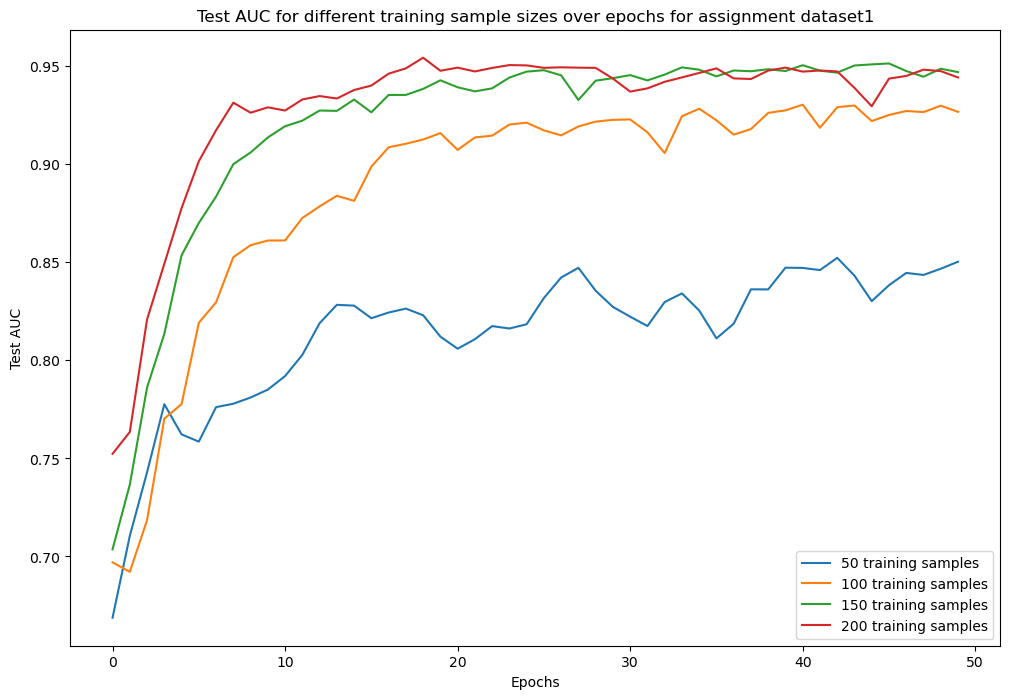

In [23]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))

# loop over each num_train_samples
for num_samples, aucs in auc_results.items():
    plt.plot(aucs, label=f"{num_samples} training samples")

plt.xlabel('Epochs')
plt.ylabel('Test AUC')
plt.legend()
plt.title('Test AUC for different training sample sizes over epochs for assignment dataset1')
plt.show()


In [22]:
test_auc

0.9442816468192115